In [1]:
import torch
from torch import nn

nn.Transformer只包含编码器和解码器，因此位置编码和嵌入以及最终线性层依然需要我们自己实现

# 位置嵌入与编码

In [2]:
class EmbeddingPositionEncode(nn.Module):
    def __init__(self, d_model, dropout: float, vocab_size):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # x_1:(batch_size,seq_len,d_model)
        x_1 = self.embedding(input_tensor)
        seq_len = input_tensor.size(1)

        # 创建位置编码(正余弦)
        position = torch.arange(seq_len, device=input_tensor.device).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, self.d_model, 2, device=input_tensor.device)
            * (
                    -torch.log(torch.tensor(10000.0, device=input_tensor.device))
                    / self.d_model
            )
        )

        pos_encoding = torch.zeros(seq_len, self.d_model, device=input_tensor.device)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        # 添加位置编码
        x_2 = pos_encoding.unsqueeze(0)
        return self.dropout(x_1 + x_2)

# 完整模型

In [3]:
class ChEnTransformer(nn.Module):
    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        d_model: int = 512,
        nhead: int = 8,
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.pos_embed_encoder_layer = EmbeddingPositionEncode(
            d_model, dropout, src_vocab_size
        )
        self.pos_embed_decoder_layer = EmbeddingPositionEncode(
            d_model, dropout, tgt_vocab_size
        )
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            batch_first=True,
        )
        self.linear = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, tgt_mask, src_key_padding_mask, tgt_key_padding_mask):
        src_processed = self.pos_embed_encoder_layer(src)
        tgt_processed = self.pos_embed_decoder_layer(tgt)
        out = self.transformer(
            src=src_processed,
            tgt=tgt_processed,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_is_causal=True,
        )

        return self.linear(out)

# 训练

total_steps: 150,warmup_steps: 60


d:\PythonJieShiQI\Lib\site-packages\torch\nn\functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
d:\PythonJieShiQI\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


epoch 10, loss: 4.678113, perplexity: 107.566948,val_loss: 5.115238666534424
epoch 20, loss: 4.060986, perplexity: 58.031506,val_loss: 5.297893524169922
epoch 30, loss: 3.219004, perplexity: 25.003214,val_loss: 5.526024341583252
epoch 40, loss: 2.138834, perplexity: 8.489531,val_loss: 5.710995197296143
epoch 50, loss: 1.359511, perplexity: 3.894288,val_loss: 6.698295593261719
epoch 60, loss: 1.071353, perplexity: 2.919326,val_loss: 7.1284074783325195
epoch 70, loss: 0.428500, perplexity: 1.534953,val_loss: 8.109085083007812
epoch 80, loss: 0.222777, perplexity: 1.249542,val_loss: 8.764952659606934
epoch 90, loss: 0.133744, perplexity: 1.143100,val_loss: 8.961273193359375
epoch 100, loss: 0.095231, perplexity: 1.099913,val_loss: 9.084965705871582
epoch 110, loss: 0.100496, perplexity: 1.105719,val_loss: 9.615668296813965
epoch 120, loss: 0.084948, perplexity: 1.088660,val_loss: 9.811363220214844
epoch 130, loss: 0.084358, perplexity: 1.088019,val_loss: 9.814030647277832
epoch 140, loss:

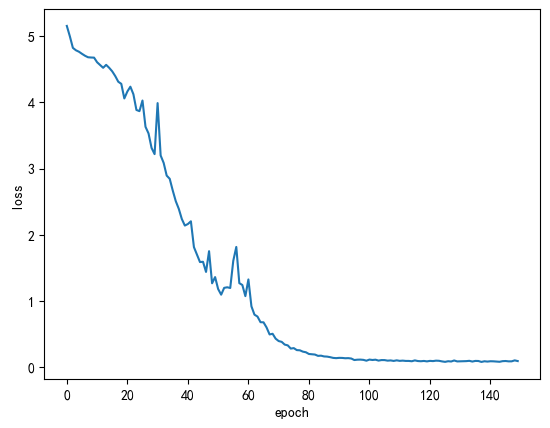

In [5]:
import matplotlib.pyplot as plt
from TranslationDataset import TranslationDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split


def save_checkpoint(epoch, model, optimizer, scheduler, loss, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "scheduler_type": type(scheduler).__name__,
        "loss": loss,
    }
    torch.save(checkpoint, path)


def load_checkpoint(model, optimizer, scheduler, path):
    if path is not None:
        checkpoint = torch.load(path)
        if model:
            model.load_state_dict(checkpoint["model_state_dict"])
        if optimizer:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            print(f"从{checkpoint['epoch']}开始训练")
        if scheduler:
            scheduler.load_state_dict(checkpoint["scheduler_state"])
        return checkpoint["epoch"], checkpoint["loss"]

    print("未发现检查点")
    return 0, float("inf")


dataset = TranslationDataset(
    file_path="../data/translate/TranslationData.csv",
    max_lines=10,
)

train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])  # 百分之九十作为训练集

device = "cuda"
src_vocab_size = len(dataset.ch_token_to_index)
tgt_vocab_size = len(dataset.en_token_to_index)
model = ChEnTransformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=64,
    dropout=0,
).to(device)

epochs = 150
lr = 1.0
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-9,  # weight_decay=1e-4
)
padding_idx = dataset.en_token_to_index["<pad>"]
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_idx)
batch_size = 10

train_loader, test_loader = DataLoader(
    train_dataset, batch_size=batch_size
), DataLoader(test_dataset, batch_size=batch_size)

total_steps = int(epochs * (len(dataset) / batch_size))
warmup_steps = int(total_steps * 0.4)
print(f"total_steps: {total_steps},warmup_steps: {warmup_steps}")
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda step: (
        512 ** (-0.5)  # 模型维度的平方根倒数
        * min(
            (step + 1) ** (-0.5),  # 衰减阶段：步长的平方根倒数
            (step + 1) * (warmup_steps ** (-1.5)),  # 预热阶段：线性增长
        )
    ),
)


def evaluate(model, test_loader, device):
    model.eval().to(device)
    total_val_loss = 0
    with torch.no_grad():
        for src,tgt in test_loader:
            total_val_loss = 0
            # 处理解码器输入和目标
            tgt_input = tgt[:, :-1]  # 解码器输入：去掉最后一个token（<eos>/<pad>）
            tgt_target = tgt[:, 1:]  # 预测目标：去掉第一个token（<bos>）

            # 生成填充掩码
            src_key_padding_mask = (src == dataset.ch_token_to_index["<pad>"]).to(device)
            tgt_key_padding_mask = (tgt_input == dataset.en_token_to_index["<pad>"]).to(
                device
            )
            # 生成因果掩码
            # 用nn.Transformer的内置方法生成正方形后续掩码
            tgt_input_seq_len = tgt_input.shape[1]
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_input_seq_len).to(
                device
            )
            src, tgt_input, tgt_target = (
                src.to(device),
                tgt_input.to(device),
                tgt_target.to(device),
            )

            pred = model(
                src=src,
                tgt=tgt_input,
                tgt_mask=tgt_mask,
                src_key_padding_mask=src_key_padding_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
            )

            # 计算损失和优化
            loss = loss_fn(pred.reshape(-1, tgt_vocab_size), tgt_target.reshape(-1))
            total_val_loss += loss.item()
    return total_val_loss / len(test_loader)


error = []
path = None  # 如果你有保存好的模型，在这里填充具体的文件路径
start_epoch = 0
# start_epoch, loss = load_checkpoint(model, optimizer, scheduler, path)

for epoch in range(start_epoch, epochs):
    model.train().to(device)
    total_loss = 0
    best_val_loss = 1e10
    for src, tgt in train_loader:
        # 处理解码器输入和目标
        tgt_input = tgt[:, :-1]  # 解码器输入：去掉最后一个token（<eos>/<pad>）
        tgt_target = tgt[:, 1:]  # 预测目标：去掉第一个token（<bos>）

        # 生成填充掩码
        src_key_padding_mask = (src == dataset.ch_token_to_index["<pad>"]).to(device)
        tgt_key_padding_mask = (tgt_input == dataset.en_token_to_index["<pad>"]).to(
            device
        )
        # 生成因果掩码
        # 用nn.Transformer的内置方法生成正方形后续掩码
        tgt_input_seq_len = tgt_input.shape[1]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_input_seq_len).to(
            device
        )
        src, tgt_input, tgt_target = (
            src.to(device),
            tgt_input.to(device),
            tgt_target.to(device),
        )

        # 与我们自己实现的模型不同，这里删除tgt_mask参数，依赖tgt_is_causal=True自动生成
        pred = model(
            src=src,
            tgt=tgt_input,
            tgt_mask=tgt_mask,  # 无需手动传掩码
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
        )

        # 计算损失和优化
        loss = loss_fn(pred.reshape(-1, tgt_vocab_size), tgt_target.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    val_loss = evaluate(model, test_loader, device)
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), "best_model.pth")  # 保存最佳模型
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(
            f"epoch {epoch + 1}, loss: {avg_loss:.6f}, perplexity: {torch.exp(torch.tensor(avg_loss)).item():.6f},val_loss: {val_loss}"
        )
    # 如果你需要保存模型，取消下面的注释并更改path_to_save为具体的文件路径
    # if (epoch + 1) % 50 == 0: #
    #     save_checkpoint(epoch + 1, model, optimizer, scheduler, loss, path)
    #     path_to_save = None
    #     print(f"已保存为{path}")
    error.append(loss.item())
plt.plot(error)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 预测

In [6]:
def preprocess_chinese(sentence, ch_token_to_index, max_length):
    """预处理中文句子，转换为张量（保持不变）"""
    tokens = sentence.split()
    index_tokens = [ch_token_to_index.get(token, ch_token_to_index["<unk>"]) for token in tokens]
    index_tokens = [ch_token_to_index["<bos>"]] + index_tokens + [ch_token_to_index["<eos>"]]
    if len(index_tokens) < max_length:
        index_tokens += [ch_token_to_index["<pad>"]] * (max_length - len(index_tokens))
    else:
        index_tokens = index_tokens[:max_length]
    return torch.tensor(index_tokens, dtype=torch.long).unsqueeze(0)


def translate(chinese_sentence, model, dataset, device):
    """
    适配PyTorch官方Transformer的翻译函数
    """
    model.eval()
    ch_token_to_index = dataset.ch_token_to_index
    en_token_to_index = dataset.en_token_to_index
    en_index_to_token = dataset.en_index_to_token
    
    # 预处理中文输入
    src_tensor = preprocess_chinese(
        chinese_sentence, 
        ch_token_to_index, 
        dataset.ch_max_length
    ).to(device)
    src_key_padding_mask = (src_tensor == ch_token_to_index["<pad>"]).to(device)
    
    # 获取编码器输出
    with torch.no_grad():
        # 先进行嵌入和位置编码
        src_processed = model.pos_embed_encoder_layer(src_tensor)
        # 调用官方编码器
        encoder_out = model.transformer.encoder(
            src=src_processed,
            src_key_padding_mask=src_key_padding_mask,
            is_causal=False  # 编码器不需要因果掩码
        )
    
    # 自回归生成英文翻译
    tgt_tokens = [en_token_to_index["<bos>"]]  # 从起始标记开始
    tgt_tensor = torch.tensor(tgt_tokens, dtype=torch.long).unsqueeze(0).to(device)
    
    for _ in range(dataset.en_max_length - 1):
        # 生成当前目标序列的因果掩码
        tgt_seq_len = tgt_tensor.shape[1]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(device)
        
        # 生成目标序列的填充掩码
        tgt_key_padding_mask = (tgt_tensor == en_token_to_index["<pad>"]).to(device)
        
        # 解码器前向传播
        with torch.no_grad():
            # 目标序列嵌入和位置编码
            tgt_processed = model.pos_embed_decoder_layer(tgt_tensor)
            # 调用官方解码器
            decoder_out = model.transformer.decoder(
                tgt=tgt_processed,
                memory=encoder_out,
                tgt_mask=tgt_mask,
                memory_key_padding_mask=src_key_padding_mask,  # 复用源序列的填充掩码
                tgt_key_padding_mask=tgt_key_padding_mask,
                tgt_is_causal=True,  # 明确因果关系
                memory_is_causal=False
            )

            pred_logits = model.linear(decoder_out)
            # 取最后一个位置的预测结果
            next_token_idx = torch.argmax(pred_logits[:, -1, :], dim=-1).item()
        
        # 更新目标序列
        tgt_tokens.append(next_token_idx)
        tgt_tensor = torch.tensor(tgt_tokens, dtype=torch.long).unsqueeze(0).to(device)
        
        # 停止
        if next_token_idx == en_token_to_index["<eos>"]:
            break
    
    return [en_index_to_token[idx] for idx in tgt_tokens]



chinese_input = '缔约国 根据 《 任择 议定书 》 第 12 条 第 1 款 提交 的 初次 报告 的 准则 由 委员会 在 2002 年 2 月 1 日 第 777 次 会议 上 通过 。'

# 执行翻译
translated_result = translate(chinese_input, model, dataset, device)

# 输出结果
print("中文输入:", chinese_input)
print("英文翻译:", ' '.join(translated_result))


中文输入: 缔约国 根据 《 任择 议定书 》 第 12 条 第 1 款 提交 的 初次 报告 的 准则 由 委员会 在 2002 年 2 月 1 日 第 777 次 会议 上 通过 。
英文翻译: <bos> guidelines regarding initial reports to be submitted by States parties under article 12 , paragraph 1 , of the Optional Protocol were adopted by the Committee at its 777th meeting , on 1 February 2002 . <eos>


# 模型泛化

In [ ]:
dataset = TranslationDataset(
    file_path="../data/translate/2m_WMT21.csv",
    max_lines=1500000,# 大样本
)
device = "cuda" if torch.cuda.is_available() else "cpu"
src_vocab_size = len(dataset.ch_token_to_index)
tgt_vocab_size = len(dataset.en_token_to_index)
model = ChEnTransformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=512,
    dropout=0.3,
).to(device)
# 同样地，训练步骤不变,训练10-15个epoch即可
# 训练步骤....